In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne

import sklearn as sk
import pandas as pd

# Input: data

Here we setup the data to feed it to the classifier model.

The data is located in the folder `../data/EDF_format/`. Each file name and the class it belongs to (Y, output variable) is listed in `../data/eeg_grades.csv`.

We want to create columns (lists): file_ID or ID, grade, `fileref`*. The fileref column contains the reference to the EDF file open via `mne.io.read_raw_edf()` from which the manipulations are done. We then slice each file into multiple epochs of fixed length.

The input dataframe for the classifier model will have columns: fileID_epochNum | grade (class) | extracted features

In [3]:
### importing dataset info from eeg_grades.csv: fileID, babyID, num, grade
### we want 'fileID' and 'grade'

import csv

data_info = {}
data_classes = {}
# get data info from eeg_grades.csv
info_filepath = "../data/eeg_grades.csv"
with open(info_filepath, 'r') as csv_file:
    reader = csv.reader(csv_file)
    next(reader)  # skip header line
    for row in reader:
        data_info[row[0]] = (row[1], row[2], row[3])
        data_classes[row[0]] = row[3]

In [4]:
# setting up data files

files_basepath = "../data/EDF_format/"
files_names_all = list(data_classes.keys())
files_names = [name for name, c in data_classes.items() if c != '']
data_files = {}
for filename in files_names:
    file = mne.io.read_raw_edf(files_basepath+filename+".edf", preload=True, verbose=False)
    data_files[filename] = (file)

In [5]:
# importing the data
# to load data into memory we need to:
raw = data_files[files_names[0]].load_data()

In [6]:
print("EDF information")
channels = raw.ch_names
print("Channels: " + ','.join(raw.ch_names))
sfreq = raw.info['sfreq']
print("Sampling frequency: " + str(raw.info['sfreq']))
print("Duration (s): " +  str(float(raw.n_times)/raw.info['sfreq']) )

EDF information
Channels: F4,C4,T4,O2,F3,C3,T3,O1,Cz
Sampling frequency: 256.0
Duration (s): 3600.0


In [7]:
# set EEG ref as Cz? https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html
# need to load data to work (preload=True, or raw.load_data)
# we also drop Cz as it is now a reference
for raw_id in files_names:
    data_files[raw_id].set_eeg_reference(ref_channels=['Cz'], verbose=False)
    data_files[raw_id] = data_files[raw_id].drop_channels('Cz')

channels = data_files[files_names[0]].ch_names

Each datafile has an EEG recording (duration 1 h or 3600 s) for 9 channels.
For each datafile a class (grade from 1 to 4) is given. (If not given, this is the validation set)

In [8]:
# For each datafile, separate into epochs.

epoch_duration = 30 # in seconds
epoch_overlap_t = 0

data_epochs = {}

for fid, file in data_files.items():
    data_epochs[fid] = mne.make_fixed_length_epochs(
        file, duration=epoch_duration, overlap=epoch_overlap_t, verbose=False)


ID04_epoch2
Using data from preloaded Raw for 1 events and 6000 original time points ...
0 bad epochs dropped
Using matplotlib as 2D backend.
Opening epochs-browser...
Using data from preloaded Raw for 1 events and 6000 original time points ...


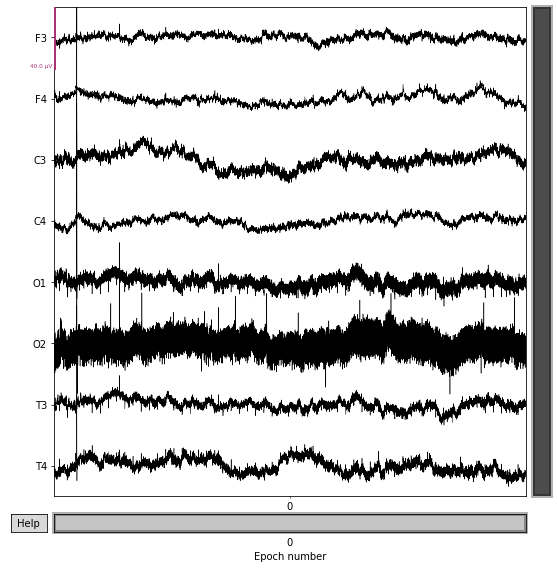

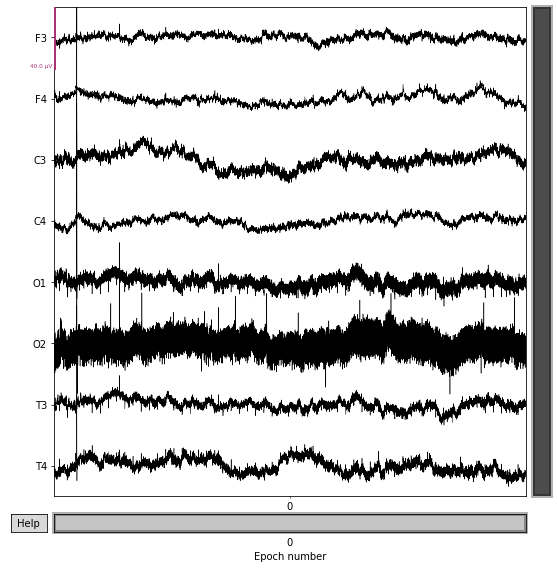

In [9]:
# for each epoch we will extract the psd_welch for each channel
fid = files_names[5]
print(fid)
epoch = data_epochs[fid][0]

epoch.plot()    

Using data from preloaded Raw for 1 events and 6000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


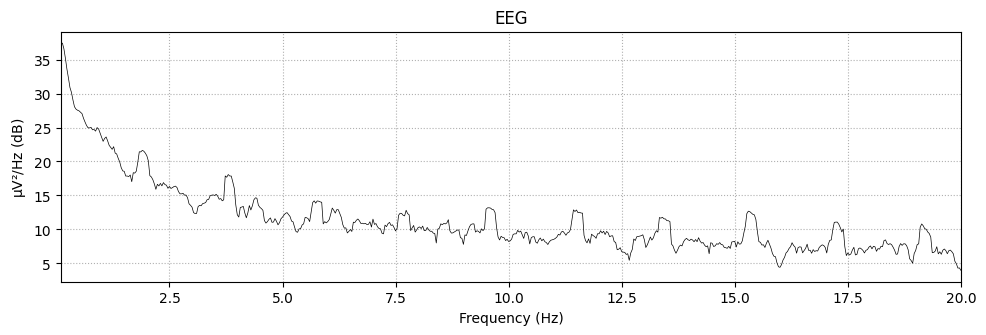

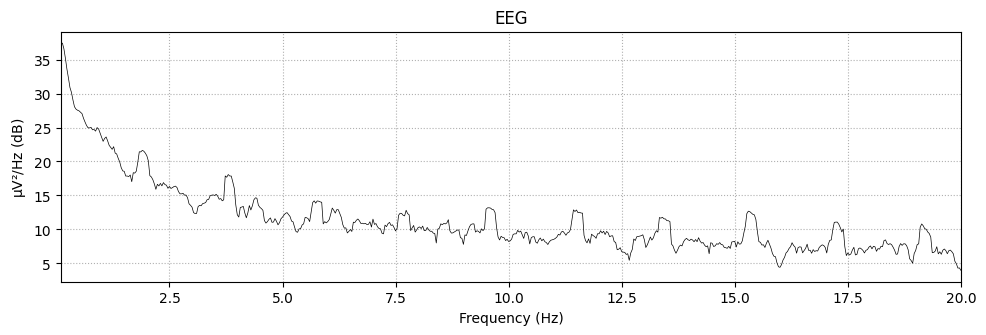

In [10]:
epoch.plot_psd(area_mode=None, fmin=0.1, fmax=20.0, show=False, average=True)

In [11]:
epoch_psds, epoch_psds_freqs = mne.time_frequency.psd_welch(epoch, fmin=0.1, fmax=30.0, verbose=False)

In [12]:
len(epoch_psds_freqs)

38

In [13]:
# epoch_psds is a ndarray

epoch_psds.shape

## this means I have one value for each frequency (38 freqs) at each channel

(1, 8, 38)

so now we build a pandas dataframe in the shape:

fileID_epochID (index) | class (y) | PSD_Ch1 (shape = array) | ... | PSD_Ch9 (array)  (9 features of np.array)

OR

fileID_epochID (index) | class (y) | PSD_Ch1_F1 (shape = float) | PSD_Ch1_F2 | ... | PSD_Ch9_F38 (float)  (38*9 = 342 features)

I will try the second method:

In [29]:
# 30s @ 200 Hz
epoch_len = 30*200

In [31]:
# freq bins for aggregation
freqs = np.geomspace(0.1, 30.0, num=9)
freq_bins = [(freqs[i], freqs[i+1]) for i in range(len(freqs)-1)]
freq_bins
n_points_fft = 1024 

In [35]:
fid = files_names[5]

epochs = data_epochs[fid]
epochs_psds, epochs_psds_freqs = mne.time_frequency.psd_welch(
        epochs, fmin=0.1, fmax=30.0, n_fft=1024, verbose=False)
print(epochs_psds.shape)

X = []
for (fmin,fmax) in freq_bins:
        psds_bands = epochs_psds[:, :, (epochs_psds_freqs >= fmin) & (epochs_psds_freqs < fmax)].mean(axis=-1)
        X.append(psds_bands.reshape(len(epochs_psds), -1))

print(X[0].shape)

d = np.concatenate(X, axis=1)
d.shape

(120, 8, 153)
(120, 8)


(120, 64)

In [33]:
cols = []

for i in range(len(freq_bins)):
    for ch_name in channels:
        cols.append('PSD_{:s}_f{:d}'.format(ch_name, i))


In [59]:
df = pd.DataFrame(columns=(cols+['grade']))

fids = [files_names[i] for i in range(3)]

for fid, epochs in data_epochs.items():
# for fid in fids:
    # epochs = data_epochs[fid]
    epochs.drop_bad()
    n_epochs = len(epochs)
    epochs_psds, epochs_psds_freqs = mne.time_frequency.psd_welch(
        epochs, fmin=0.1, fmax=30.0, n_fft=2048, verbose=False)
    epochs_psds /= np.sum(epochs_psds, axis=-1, keepdims=True)
    X = []
    for (fmin,fmax) in freq_bins:
        psds_bands = epochs_psds[:, :, (epochs_psds_freqs >= fmin) & (epochs_psds_freqs < fmax)].mean(axis=-1)
        X.append(psds_bands.reshape(len(epochs_psds), -1))
    X = np.concatenate(X, axis=1)
    epochs_features = pd.DataFrame(X, columns=cols, dtype=np.dtype(float))
    epochs_features['grade'] = [data_classes[fid]]*n_epochs

    df = pd.concat([df, epochs_features], ignore_index=True)
    

C:\Users\caroline.peres\AppData\Local\Temp\ipykernel_8508\2055112864.py:12: RuntimeWarning: invalid value encountered in true_divide
  epochs_psds /= np.sum(epochs_psds, axis=-1, keepdims=True)
C:\Users\caroline.peres\AppData\Local\Temp\ipykernel_8508\2055112864.py:12: RuntimeWarning: invalid value encountered in true_divide
  epochs_psds /= np.sum(epochs_psds, axis=-1, keepdims=True)
C:\Users\caroline.peres\AppData\Local\Temp\ipykernel_8508\2055112864.py:12: RuntimeWarning: invalid value encountered in true_divide
  epochs_psds /= np.sum(epochs_psds, axis=-1, keepdims=True)


In [61]:
df[cols] = df[cols].astype('float')
df['grade'] = df['grade'].astype('category')

In [62]:
df.describe()

,PSD_F4_f0,PSD_C4_f0,PSD_T4_f0,PSD_O2_f0,PSD_F3_f0,PSD_C3_f0,PSD_T3_f0,PSD_O1_f0,PSD_F4_f1,PSD_C4_f1,...,PSD_T3_f6,PSD_O1_f6,PSD_F4_f7,PSD_C4_f7,PSD_T4_f7,PSD_O2_f7,PSD_F3_f7,PSD_C3_f7,PSD_T3_f7,PSD_O1_f7
count,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,...,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04,1.256900e+04
mean,0.298990,0.300659,0.324644,0.322456,0.320663,0.309901,0.308756,0.317334,0.124160,0.123183,...,2.970209e-04,2.487347e-04,1.536306e-04,9.407393e-05,6.177579e-05,8.978065e-05,1.075541e-04,7.181191e-05,1.347590e-04,1.094902e-04
std,0.207325,0.203387,0.204151,0.198145,0.204150,0.197934,0.202868,0.204514,0.064931,0.061076,...,5.437518e-04,3.809182e-04,3.407251e-04,1.835147e-04,1.582532e-04,3.161049e-04,2.689994e-04,1.544118e-04,3.657414e-04,2.863888e-04
min,0.000342,0.000579,0.000921,0.004937,0.003670,0.004462,0.000540,0.001179,0.003274,0.003738,...,1.827065e-07,7.297626e-08,3.164174e-08,1.628385e-08,1.702160e-08,1.334726e-08,3.459467e-08,1.292656e-08,3.871085e-08,1.094643e-08
25%,0.136141,0.144965,0.163945,0.165529,0.155185,0.154221,0.148830,0.158051,0.075654,0.076986,...,6.180168e-05,5.939906e-05,1.352560e-05,1.503209e-05,1.022337e-05,9.820682e-06,1.115217e-05,1.306690e-05,1.372886e-05,1.195665e-05
50%,0.241082,0.248865,0.280653,0.284347,0.279195,0.268040,0.266047,0.275947,0.113499,0.114590,...,1.640056e-04,1.547426e-04,3.855904e-05,3.336064e-05,2.415030e-05,2.253546e-05,2.616541e-05,2.991460e-05,3.297452e-05,2.860571e-05
75%,0.427825,0.410502,0.449451,0.446545,0.455409,0.429324,0.434058,0.442820,0.162632,0.160477,...,2.937111e-04,2.699642e-04,1.408829e-04,7.558378e-05,4.924177e-05,4.598942e-05,6.572177e-05,5.799052e-05,7.298749e-05,5.812278e-05
max,0.963979,0.975590,0.960756,0.969689,0.975435,0.978642,0.970296,0.966965,0.444907,0.442688,...,7.448045e-03,5.228595e-03,4.935228e-03,2.364514e-03,3.282758e-03,4.610817e-03,4.706494e-03,2.255607e-03,4.450578e-03,3.889575e-03


# Model

In [83]:
data_df = df.dropna()
print(len(df.index))
print(len(data_df.index))

12600
12569


In [84]:
y = data_df['grade']
X = data_df[cols]

y

0        1
1        1
2        1
3        1
4        1
        ..
12595    2
12596    2
12597    2
12598    2
12599    2
Name: grade, Length: 12569, dtype: category
Categories (4, object): ['1', '2', '3', '4']

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1 - SVM

In [97]:
from sklearn import svm

clf_svm = svm.SVC().fit(X_train, y_train)
clf_svm.score(X_test, y_test)

0.6539379474940334

## 2 - Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier().fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.8210023866348448

## 3 - NN

In [103]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier(hidden_layer_sizes=(150,100,50),max_iter=500, early_stopping=True).fit(X_train, y_train)
clf_nn.score(X_test, y_test)

c:\Users\caroline.peres\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\caroline.peres\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\caroline.peres\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\caroline.peres\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\caroline.peres\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not h

0.7334924423229913

## Next:

- Confusion matrix, precision-recall, and other evaluation metrics
- Cross validation: https://scikit-learn.org/stable/modules/cross_validation.html
- More feature engineering?

different classifiers: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py